In [48]:
from pathlib import Path
import json
import numpy as np

# Project root: repo_root/notebooks/01_generate_shapes_images.ipynb
ROOT = Path("..").resolve()

# Choose ONE input:
# INPUT = ROOT / "data" / "mats" / "dog_343_occ.mat"
# INPUT = ROOT / "data" / "mats" / "master_lib.mat"
CASE = "dog_8_val_5"

GENERATED_MAT = ROOT / "data" / "cases" / CASE / "generated" / f"{CASE}.jsonl"   # example
MASTER_LIB    = ROOT / "data" / "master" / "master_lib.mat" 

OUT_DIR = ROOT / "data" / "cases" / CASE
WITH_OCC_DIR = OUT_DIR 
NO_OCC_DIR = OUT_DIR 
RAND_DIR = OUT_DIR / "generated" / "completions"

for d in [WITH_OCC_DIR, NO_OCC_DIR, RAND_DIR]:
    d.mkdir(parents=True, exist_ok=True)

H = 600
W = 900
MARGIN = 5
SUPERSAMPLE = 4

SEED = 4 #1, 2, 3, 4, 5, 6, 7, 8, 9, 1000083
rng = np.random.default_rng(SEED)

print("ROOT:", ROOT)
print("INPUT:", GENERATED_MAT)
print("OUT_DIR:", OUT_DIR)

import sys
sys.path.append(str(ROOT / "scripts"))

from shape_gen.io_mat import load_generated_case, unit_to_pixel


def load_case_from_jsonl(jsonl_path: Path, *, line_index: int = -1, default_baseGrid: int = 256):
    """
    Accepts TWO JSONL schemas:

    A) Pipeline schema (preferred):
       silhouette_u, occluder_u, baseGrid, sil_class

    B) Your current schema:
       shape_contour_xy, occluder_rect_xy, (optional) coord_system, (optional) H/W
       . We'll treat these as unit coords and set baseGrid = default_baseGrid unless present.
    """
    lines = jsonl_path.read_text(encoding="utf-8").splitlines()
    if not lines:
        raise ValueError(f"Empty JSONL: {jsonl_path}")
    row = json.loads(lines[line_index])

    # --- Schema A ---
    if "silhouette_u" in row:
        silhouette_u = np.asarray(row["silhouette_u"], dtype=np.float64)
        occluder_u = np.asarray(row.get("occluder_u", []), dtype=np.float64)
        baseGrid = int(row["baseGrid"])
        sil_class = row.get("sil_class", None)

        if occluder_u.size == 0:
            occluder_u = np.zeros((0, 2), dtype=np.float64)

        return silhouette_u, occluder_u, baseGrid, sil_class, row

    # --- Schema B (your current JSONL) ---
    if "shape_contour_xy" in row:
        silhouette_u = np.asarray(row["shape_contour_xy"], dtype=np.float64)
        occluder_u = np.asarray(row.get("occluder_rect_xy", []), dtype=np.float64)

        # Use baseGrid if present, else fall back.
        baseGrid = int(row.get("baseGrid", default_baseGrid))

        # Optional: if your JSONL stores H/W, you might want baseGrid=H (if square)
        if "H" in row and "W" in row and int(row["H"]) == int(row["W"]):
            baseGrid = int(row.get("baseGrid", row["H"]))

        sil_class = row.get("sil_class", row.get("category", None))

        if occluder_u.size == 0:
            occluder_u = np.zeros((0, 2), dtype=np.float64)

        return silhouette_u, occluder_u, baseGrid, sil_class, row

    raise KeyError(
        f"JSONL row missing expected keys. Found keys: {sorted(row.keys())}. "
        f"Expected either 'silhouette_u' or 'shape_contour_xy'."
    )


def load_case_unified(input_path: Path):
    """
    Returns:
      silhouette_u, occluder_u, baseGrid, sil_class, meta(dict)
    """
    input_path = Path(input_path)

    if input_path.suffix.lower() == ".jsonl":
        silhouette_u, occluder_u, baseGrid, sil_class, meta = load_case_from_jsonl(input_path)
        meta["source_type"] = "jsonl"
        return silhouette_u, occluder_u, baseGrid, sil_class, meta

    if input_path.suffix.lower() == ".mat":
        # generated case .mat (your existing format)
        case = load_generated_case(input_path)
        meta = {"source_type": "mat", "source_mat": str(input_path)}

        silhouette_u = case.silhouette_u
        occluder_u = case.occluder_u
        baseGrid = case.base_grid
        sil_class = case.sil_class

        return silhouette_u, occluder_u, baseGrid, sil_class, meta

    raise ValueError(f"Unsupported input type: {input_path.suffix}")


silhouette_u, occluder_u, baseGrid, sil_class, meta = load_case_unified(GENERATED_MAT)

silhouette = unit_to_pixel(silhouette_u, baseGrid)
occluder = unit_to_pixel(occluder_u, baseGrid) if occluder_u.size else np.zeros((0, 2), dtype=np.int32)

print("meta:", meta)
print("baseGrid:", baseGrid)
print("silhouette_u:", silhouette_u.shape, float(np.min(silhouette_u)), float(np.max(silhouette_u)))
print("occluder_u:", occluder_u.shape)
print("silhouette:", silhouette.shape, silhouette.dtype)
print("occluder:", occluder.shape, occluder.dtype)
print("sil_class:", sil_class)


ROOT: /home/hschatzle/monte-carlo-selection
INPUT: /home/hschatzle/monte-carlo-selection/data/cases/dog_8_val_5/generated/dog_8_val_5.jsonl
OUT_DIR: /home/hschatzle/monte-carlo-selection/data/cases/dog_8_val_5
meta: {'ts_utc': 1770050781.1343374, 'source_mat': '/home/hschatzle/monte-carlo-selection/data/master/master_lib.mat', 'category': 'dog', 'img_id': 8, 'coord_system': 'normalized_contour_space', 'shape_contour_xy': [[0.00021698488662300216, 0.7751907681944187], [0.004583515866681863, 0.7838897918608364], [0.012436567714170597, 0.790298679479539], [0.020289619561659294, 0.7967075670982414], [0.027544478999290738, 0.8025182623070866], [0.035820516756244036, 0.8079059716064672], [0.044096554513197286, 0.8132936809058477], [0.05244122544734873, 0.8185156950580076], [0.0606486300271037, 0.8240690995046089], [0.06892466778405695, 0.8294568088039896], [0.07678601658570125, 0.8358456658034433], [0.08463077147903449, 0.8422745840413945], [0.08831100284258722, 0.8512578823168204], [0.08831

In [49]:
from shape_gen.geom_bbox import compute_bbox

polys_for_bbox = [silhouette]
if occluder.size:
    polys_for_bbox.append(occluder)

minX, minY, wBB, hBB = compute_bbox(
    polys_for_bbox,
    base_grid=baseGrid,
    margin=MARGIN
)

print(f"Bounding box -> minX={minX}, minY={minY}, wBB={wBB}, hBB={hBB}, baseGrid={baseGrid}")


Bounding box -> minX=1, minY=140, wBB=256, hBB=99, baseGrid=256


In [50]:
from shape_gen.render import draw_and_save

silhouette_index = 1

imgA = WITH_OCC_DIR / "occluded.png"
imgB = NO_OCC_DIR / "gt.png"

# Silhouette only
draw_and_save(
    polygons=[silhouette],
    colors=[[0, 0, 0]],
    minX=minX, minY=minY, wBB=wBB, hBB=hBB,
    out_w=W, out_h=H,
    out_file=imgB,
    supersample=SUPERSAMPLE
)

# Silhouette + occluder
if occluder.size:
    draw_and_save(
        polygons=[silhouette, occluder],
        colors=[[0, 0, 0], [131, 131, 131]],
        minX=minX, minY=minY, wBB=wBB, hBB=hBB,
        out_w=W, out_h=H,
        out_file=imgA,
        supersample=SUPERSAMPLE
    )
else:
    print("Occluder is empty. Skipping silhouette+occluder image.")

print("Wrote:", imgB)
if occluder.size:
    print("Wrote:", imgA)


Wrote: /home/hschatzle/monte-carlo-selection/data/cases/dog_8_val_5/gt.png
Wrote: /home/hschatzle/monte-carlo-selection/data/cases/dog_8_val_5/occluded.png


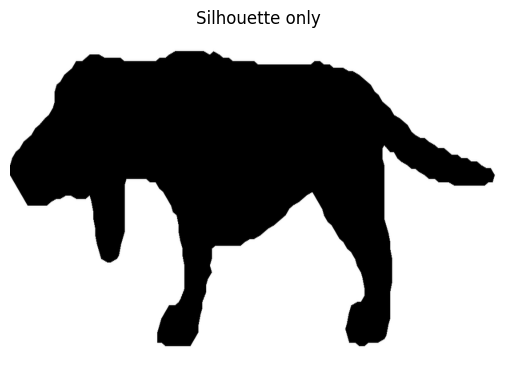

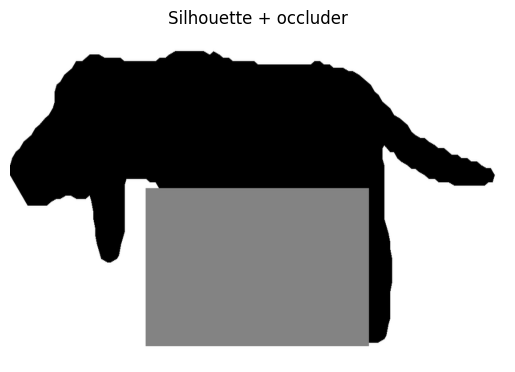

In [51]:
from PIL import Image
import matplotlib.pyplot as plt

def show(path, title):
    im = Image.open(path)
    plt.figure()
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")
    plt.show()

show(imgB, "Silhouette only")
if occluder.size:
    show(imgA, "Silhouette + occluder")


In [44]:
from shape_gen.intersections2 import find_intersection_points_multiple

intersection_points = np.zeros((0, 2), dtype=np.float64)
start_pt = None
end_pt = None

if occluder.size:
    intersection_points = find_intersection_points_multiple(silhouette, occluder, eps_merge=1e-3)

    print("intersection_points shape:", intersection_points.shape)
    print(intersection_points)

    if intersection_points.shape[0] < 2:
        raise RuntimeError("No valid intersection points between silhouette and occluder.")

    start_pt = intersection_points[0, :]
    end_pt = intersection_points[1, :]

    print("start_pt:", start_pt, "end_pt:", end_pt)
else:
    print("Occluder empty. Skipping intersections.")


intersection_points shape: (2, 2)
[[186. 146.]
 [ 78. 192.]]
start_pt: [186. 146.] end_pt: [ 78. 192.]


In [45]:
import shape_gen.library as lib
import importlib
importlib.reload(lib)

from shape_gen.library import load_master_records, build_class_index

records = load_master_records(MASTER_LIB)
classes, byClass = build_class_index(records)

print("Loaded records:", len(records))
print("Num classes:", len(classes))
print("Example classes:", classes[:10])


Loaded records: 54000
Num classes: 54
Example classes: ['ant', 'bat', 'bear', 'bee', 'beetle', 'bird', 'bug', 'bull', 'butterfly', 'camel']


# Parallel Version

In [46]:
# =========================
# ADJUSTED: parallel wrapper cell (8 cores, 10k attempts) tuned for SMALL SPACES
# =========================
# Constraints unchanged. Only adjust the CALL PARAMETERS you already expose.
# Goal: increase acceptance probability in tight occluders without touching validators.
#
# Key changes:
# - fraction: smaller donor fragments fit tight corridors better
# - final_n_samples_mode: use matlab_100 to avoid overly dense sampling-induced failures
# - max_attempts_per_image: increase to compensate for harsher feasibility (still bounded)
# - try_mirror: keep True (helps)
# - smooth_win: slightly higher to reduce micro-wiggles
# - shrink_gamma/max_shrink_iters: allow more aggressive / more iterations of shrink search
# - refit: reduce degrees-of-freedom a bit to avoid overshoot/self-cross in tiny regions

from __future__ import annotations

import os
import re
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np

from shape_gen.generate_parallel import generate_completions, save_metadata_jsonl
from shape_gen.heatmap.xy_store import save_xy_npz


def _worker_run(args: dict) -> dict:
    wid = int(args["worker_id"])
    out_dir = Path(args["out_dir"])
    tmp_dir = Path(args["tmp_dir"])
    tmp_dir.mkdir(parents=True, exist_ok=True)
    warp_enabled=bool(args["warp_enabled"]),
    warp_k_modes=int(args["warp_k_modes"]),
    warp_amp_rel=float(args["warp_amp_rel"]),
    warp_n_steps=int(args["warp_n_steps"]),
    warp_max_attempts=int(args["warp_max_attempts"]),
    warp_decay=float(args["warp_decay"]),


    seed = int(args["seed"])
    rng = np.random.default_rng(seed)

    metas, out_files_xy, polygons_xy = generate_completions(
        silhouette=args["silhouette"],
        occluder=args["occluder"],
        start_pt=args["start_pt"],
        end_pt=args["end_pt"],
        minX=int(args["minX"]),
        minY=int(args["minY"]),
        wBB=int(args["wBB"]),
        hBB=int(args["hBB"]),
        out_w=int(args["out_w"]),
        out_h=int(args["out_h"]),
        out_dir=out_dir,
        silhouette_index=int(args["silhouette_index"]),
        sil_class=str(args["sil_class"]),
        base_grid=int(args["base_grid"]),
        records=args["records"],
        classes=args["classes"],
        byClass=args["byClass"],
        n_images=int(args["n_attempts"]),
        rng=rng,
        start_index=int(args["start_index"]),
        fraction=float(args["fraction"]),
        final_n_samples_mode=str(args["final_n_samples_mode"]),
        supersample=int(args["supersample"]),
        flush_every=int(args["flush_every"]),
        max_attempts_per_image=int(args["max_attempts_per_image"]),
        require_valid=bool(args["require_valid"]),
        snap_intersections_to_vertices=bool(args["snap_intersections_to_vertices"]),
        refit_enabled=bool(args["refit_enabled"]),
        refit_n_ctrl=int(args["refit_n_ctrl"]),
        refit_subdiv=int(args["refit_subdiv"]),
        refit_jitter_sigma=float(args["refit_jitter_sigma"]),
        refit_max_attempts=int(args["refit_max_attempts"]),
        shrink_gamma=float(args["shrink_gamma"]),
        max_shrink_iters=int(args["max_shrink_iters"]),
        smooth_win=int(args["smooth_win"]),
        try_mirror=bool(args["try_mirror"]),
        save_invalid=bool(args["save_invalid"]),
        invalid_subdir=str(args["invalid_subdir"]),
    )

    meta_path = tmp_dir / f"meta_worker_{wid:02d}.jsonl"
    save_metadata_jsonl(metas, meta_path)

    xy_path = tmp_dir / f"xy_worker_{wid:02d}.npz"
    save_xy_npz(
        xy_path,
        out_files=out_files_xy,
        polygons=polygons_xy,
        base_grid=int(args["base_grid"]),
        matlab_1_indexed=True,
    )

    return {
        "worker_id": wid,
        "meta_path": str(meta_path),
        "xy_path": str(xy_path),
        "valid_count": int(len(out_files_xy)),
        "attempts": int(args["n_attempts"]),
        "start_index": int(args["start_index"]),
    }


def _extract_completion_index_from_path(p: str) -> int:
    m = re.search(r"completion_\d{4}_(\d{5})\.png$", str(p))
    if not m:
        raise ValueError(f"Could not parse completion index from: {p}")
    return int(m.group(1))


# -------------------------
# Settings
# -------------------------
N_WORKERS = 8
TOTAL_ATTEMPTS = 10_000
ATTEMPTS_PER = TOTAL_ATTEMPTS // N_WORKERS
assert ATTEMPTS_PER * N_WORKERS == TOTAL_ATTEMPTS

BASE_SEED = 12345

COMPLETIONS_DIR = RAND_DIR
OUT_TMP = OUT_DIR / "_tmp_parallel"
OUT_TMP.mkdir(parents=True, exist_ok=True)

FLUSH_EVERY_WORKER = 1000

# -------------------------
# Small-space tuned params (only using your existing knobs)
# -------------------------
# Donor fragment shorter => easier to place in tiny occluders.
FRACTION_SMALL = 0.22          # was 0.40

# Reduce sensitivity to tiny outside excursions by limiting sampling density.
SAMPLES_MODE_SMALL = "matlab_100"   # was "match_segment"

# More retries because feasibility is harsher.
MAX_ATTEMPTS_PER_IMAGE_SMALL = 250   # was 100

# Allow more/stronger shrinking search when fit is tight.
SHRINK_GAMMA_SMALL = 0.82       # was 0.88 (more aggressive shrink per iter)
MAX_SHRINK_ITERS_SMALL = 60     # was 30

# Smooth a bit more to reduce wiggles that cause boundary violations / self-crossings.
SMOOTH_WIN_SMALL = 7            # was 5

# Refit: reduce flexibility to avoid spline overshoot in narrow corridors.
REFIT_N_CTRL_SMALL = 10         # was 14
REFIT_SUBDIV_SMALL = 18         # was 25
REFIT_JITTER_SIGMA_SMALL = 0.008  # was 0.015
REFIT_MAX_ATTEMPTS_SMALL = 12     # was 10

# -------------------------
# Build worker jobs
# -------------------------
jobs = []
for wid in range(N_WORKERS):
    start_i = wid * ATTEMPTS_PER + 1
    seed = SEED

    jobs.append(
        dict(
            worker_id=wid,
            seed=seed,
            tmp_dir=str(OUT_TMP),
            out_dir=str(COMPLETIONS_DIR),

            silhouette=silhouette,
            occluder=occluder,
            start_pt=start_pt,
            end_pt=end_pt,
            minX=minX,
            minY=minY,
            wBB=wBB,
            hBB=hBB,
            out_w=W,
            out_h=H,
            silhouette_index=1,
            sil_class=sil_class,
            base_grid=baseGrid,
            records=records,
            classes=classes,
            byClass=byClass,
            warp_enabled=True,
            warp_k_modes=6,
            warp_amp_rel=0.06,
            warp_n_steps=2,
            warp_max_attempts=10,
            warp_decay=0.65,

            n_attempts=ATTEMPTS_PER,
            start_index=start_i,

            # TUNED FOR SMALL SPACES
            fraction=FRACTION_SMALL,
            final_n_samples_mode=SAMPLES_MODE_SMALL,
            supersample=SUPERSAMPLE,
            flush_every=FLUSH_EVERY_WORKER,
            max_attempts_per_image=MAX_ATTEMPTS_PER_IMAGE_SMALL,
            require_valid=True,
            save_invalid=False,
            invalid_subdir="_invalid",
            snap_intersections_to_vertices=True,

            refit_enabled=False,
            refit_n_ctrl=REFIT_N_CTRL_SMALL,
            refit_subdiv=REFIT_SUBDIV_SMALL,
            refit_jitter_sigma=REFIT_JITTER_SIGMA_SMALL,
            refit_max_attempts=REFIT_MAX_ATTEMPTS_SMALL,

            shrink_gamma=SHRINK_GAMMA_SMALL,
            max_shrink_iters=MAX_SHRINK_ITERS_SMALL,
            smooth_win=SMOOTH_WIN_SMALL,
            try_mirror=True,
        )
    )

# -------------------------
# Run in parallel
# -------------------------
results = []
with ProcessPoolExecutor(max_workers=N_WORKERS) as ex:
    futs = [ex.submit(_worker_run, j) for j in jobs]
    for fut in as_completed(futs):
        results.append(fut.result())

results = sorted(results, key=lambda d: d["worker_id"])
print("Workers finished.")
for r in results:
    print(f"worker {r['worker_id']:02d}. attempts={r['attempts']}. valid={r['valid_count']}. start={r['start_index']}")

# -------------------------
# Merge metadata JSONL
# -------------------------
all_meta_lines = []
for r in results:
    meta_path = Path(r["meta_path"])
    all_meta_lines.extend(meta_path.read_text(encoding="utf-8").splitlines())

import json as _json
meta_rows = [_json.loads(line) for line in all_meta_lines if line.strip()]
meta_rows.sort(key=lambda d: int(d.get("completion_index", 0)))

meta_path = OUT_DIR / "shapes_meta.jsonl"
meta_path.parent.mkdir(parents=True, exist_ok=True)
with meta_path.open("w", encoding="utf-8") as f:
    for row in meta_rows:
        f.write(_json.dumps(row) + "\n")

print("Saved metadata:", meta_path)

# -------------------------
# Merge XY packs
# -------------------------
all_out_files = []
all_polygons = []

for r in results:
    npz = np.load(r["xy_path"], allow_pickle=True)
    out_files = npz["out_files"].tolist()
    polys = npz["polygons"]

    all_out_files.extend([str(p) for p in out_files])
    all_polygons.extend([polys[i] for i in range(polys.shape[0])])

pairs = list(zip(all_out_files, all_polygons))
pairs.sort(key=lambda t: _extract_completion_index_from_path(t[0]))

out_files_xy = [p[0] for p in pairs]
polygons_xy = [p[1] for p in pairs]

xy_path = OUT_DIR / "generated" / "shapes_xy.npz"
save_xy_npz(
    xy_path,
    out_files=out_files_xy,
    polygons=polygons_xy,
    base_grid=int(baseGrid),
    matlab_1_indexed=True,
)

print("Saved XY pack:", xy_path)
print("Valid completions saved:", len(out_files_xy))
print("Total meta rows:", len(meta_rows))


Attempts 1000/1250. Valid produced 1000. Last attempts=2
Attempts 1000/1250. Valid produced 1000. Last attempts=2
Attempts 1000/1250. Valid produced 1000. Last attempts=2
Attempts 1000/1250. Valid produced 1000. Last attempts=2
Attempts 1000/1250. Valid produced 1000. Last attempts=2
Attempts 1000/1250. Valid produced 1000. Last attempts=2
Attempts 1000/1250. Valid produced 1000. Last attempts=2
Attempts 1000/1250. Valid produced 1000. Last attempts=2
Workers finished.
worker 00. attempts=1250. valid=1250. start=1
worker 01. attempts=1250. valid=1250. start=1251
worker 02. attempts=1250. valid=1250. start=2501
worker 03. attempts=1250. valid=1250. start=3751
worker 04. attempts=1250. valid=1250. start=5001
worker 05. attempts=1250. valid=1250. start=6251
worker 06. attempts=1250. valid=1250. start=7501
worker 07. attempts=1250. valid=1250. start=8751
Saved metadata: /home/hschatzle/monte-carlo-selection/data/cases/dog_8_val_5/shapes_meta.jsonl
Saved XY pack: /home/hschatzle/monte-carlo

In [47]:
# =========================
# Merge worker xy packs → single shapes_xy.npz
# =========================

import re
import numpy as np
from pathlib import Path

from shape_gen.heatmap.xy_store import save_xy_npz


def extract_completion_index(p: str) -> int:
    """
    Extract global completion index from filename.
    Expects: completion_XXXX_YYYYY.png
    """
    m = re.search(r"completion_\d{4}_(\d{5})\.png$", str(p))
    if not m:
        raise ValueError(f"Could not parse completion index from: {p}")
    return int(m.group(1))


# -------------------------
# Load all worker xy packs
# -------------------------
xy_files = sorted((OUT_DIR / "_tmp_parallel").glob("xy_worker_*.npz"))
assert len(xy_files) > 0, "No worker xy files found"

all_pairs = []  # (completion_index, out_file, polygon)

for xy_path in xy_files:
    npz = np.load(xy_path, allow_pickle=True)

    out_files = npz["out_files"].tolist()
    polygons = npz["polygons"]

    assert len(out_files) == polygons.shape[0]

    for f, poly in zip(out_files, polygons):
        idx = extract_completion_index(f)
        all_pairs.append((idx, str(f), poly))


# -------------------------
# Sort by global index
# -------------------------
all_pairs.sort(key=lambda t: t[0])

out_files_xy = [p[1] for p in all_pairs]
polygons_xy  = [p[2] for p in all_pairs]

print("Total valid completions:", len(out_files_xy))


# -------------------------
# Save merged shapes_xy
# -------------------------
xy_path = OUT_DIR / "shapes_xy.npz"
save_xy_npz(
    xy_path,
    out_files=out_files_xy,
    polygons=polygons_xy,
    base_grid=int(baseGrid),
    matlab_1_indexed=True,
)

print("Saved merged XY pack:", xy_path)


Total valid completions: 10000
Saved merged XY pack: /home/hschatzle/monte-carlo-selection/data/cases/dog_8_val_5/shapes_xy.npz
